In [1]:
# load the data
import pandas as pd
df = pd.read_csv('../cleaned_dataset/labelled_ble_data.csv')

In [2]:
df.head()

,timestamp,mac address,RSSI,room
0,2023-04-10 14:21:46+09:00,6,-93,kitchen
1,2023-04-10 14:21:46+09:00,6,-93,kitchen
2,2023-04-10 14:21:46+09:00,6,-93,kitchen
3,2023-04-10 14:21:46+09:00,6,-93,kitchen
4,2023-04-10 14:21:46+09:00,6,-93,kitchen


In [3]:
# now we would group by timestamp / means that grouping by 
# each window of size = 1 second, and then for each window of 
# 1 second, we would count the top 3 most frequent mac address 
# and create the aggregated feature: top 3 beacons for each window
import pandas as pd

def create_windowed_df(df):
    windowed_records = []

    for timestamp, group in df.groupby("timestamp"):
        # count mac address frequency
        top_3 = (
            group["mac address"]
            .value_counts()
            .head(3)
            .index
            .tolist()
        )

        windowed_records.append({
            "timestamp": timestamp,
            "top_3_beacons": top_3,
            "room": group["room"].iloc[0]
        })

    windowed_df = pd.DataFrame(windowed_records)
    return windowed_df

windowed_df = create_windowed_df(df)

In [4]:
windowed_df.head()

,timestamp,top_3_beacons,room
0,2023-04-10 14:21:46+09:00,"[4, 6]",kitchen
1,2023-04-10 14:21:47+09:00,"[4, 6, 9]",kitchen
2,2023-04-10 14:21:48+09:00,"[4, 9]",kitchen
3,2023-04-10 14:21:49+09:00,"[9, 4, 7]",kitchen
4,2023-04-10 14:21:50+09:00,"[9, 4, 7]",kitchen


In [5]:
# Analysis: Beacon signature consistency per room
from collections import Counter
import numpy as np

def analyze_room_beacon_consistency(windowed_df):
    """
    For each room, find the most common top-3 beacon pattern
    and calculate how consistently it appears
    """
    results = []
    
    for room in windowed_df['room'].unique():
        room_data = windowed_df[windowed_df['room'] == room]
        
        # Convert top_3_beacons lists to tuples (so they're hashable)
        beacon_patterns = [tuple(sorted(beacons)) for beacons in room_data['top_3_beacons']]
        
        # Count pattern frequencies
        pattern_counts = Counter(beacon_patterns)
        
        # Get the most common pattern
        if pattern_counts:
            most_common_pattern, most_common_count = pattern_counts.most_common(1)[0]
            consistency = most_common_count / len(room_data)
            
            # Also calculate how many unique patterns exist
            num_unique_patterns = len(pattern_counts)
            
            results.append({
                'room': room,
                'total_windows': len(room_data),
                'most_common_pattern': most_common_pattern,
                'pattern_frequency': most_common_count,
                'consistency_score': consistency,
                'num_unique_patterns': num_unique_patterns
            })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values('consistency_score', ascending=False)

# Run the analysis
consistency_results = analyze_room_beacon_consistency(windowed_df)
print("=" * 80)
print("BEACON SIGNATURE CONSISTENCY ANALYSIS")
print("=" * 80)
print(consistency_results.to_string(index=False))
print("\n" + "=" * 80)
print(f"Average Consistency Score: {consistency_results['consistency_score'].mean():.3f}")
print(f"Median Consistency Score: {consistency_results['consistency_score'].median():.3f}")
print("=" * 80)

BEACON SIGNATURE CONSISTENCY ANALYSIS
         room  total_windows most_common_pattern  pattern_frequency  consistency_score  num_unique_patterns
          512            292               (23,)                163           0.558219                   39
          508             44               (20,)                 18           0.409091                   18
          506            257               (19,)                 95           0.369650                   34
      kitchen           5173               (14,)               1722           0.332882                  126
     cleaning            688               (19,)                188           0.273256                   93
          522            198               (22,)                 48           0.242424                   55
    cafeteria           4862               (14,)               1115           0.229329                  170
          520            311                (8,)                 71           0.228296            

In [6]:
# Analysis 2: Which single beacon appears MOST FREQUENTLY in each room's top-3?
# This is more flexible than exact pattern matching

def analyze_dominant_beacons(windowed_df):
    """For each room, find which beacons most frequently appear in top-3"""
    results = []
    
    for room in windowed_df['room'].unique():
        room_data = windowed_df[windowed_df['room'] == room]
        
        # Flatten all beacons from all top-3 lists for this room
        all_beacons_in_room = []
        for beacons in room_data['top_3_beacons']:
            all_beacons_in_room.extend(beacons)
        
        # Count beacon frequencies
        beacon_counts = Counter(all_beacons_in_room)
        total_windows = len(room_data)
        
        # Get top 3 most frequent individual beacons
        top_beacons = beacon_counts.most_common(3)
        
        if top_beacons:
            # Calculate how often the #1 beacon appears
            most_common_beacon, beacon_count = top_beacons[0]
            beacon_frequency = beacon_count / total_windows  # Can be > 1 if beacon appears multiple times per window
            
            results.append({
                'room': room,
                'total_windows': total_windows,
                'dominant_beacon': most_common_beacon,
                'appearances': beacon_count,
                'appearance_rate': min(beacon_frequency, 1.0),  # Cap at 1.0 for readability
                'top_3_beacons': [b[0] for b in top_beacons],
                'top_3_rates': [b[1]/total_windows for b in top_beacons]
            })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values('appearance_rate', ascending=False)

dominant_beacon_results = analyze_dominant_beacons(windowed_df)
print("=" * 100)
print("DOMINANT BEACON ANALYSIS - Which beacons characterize each room?")
print("=" * 100)
for _, row in dominant_beacon_results.iterrows():
    print(f"\n{row['room']:>15s} ({row['total_windows']:>5d} windows)")
    print(f"   Dominant beacon: {row['dominant_beacon']:>2d} (appears in {row['appearance_rate']:.1%} of windows)")
    print(f"   Top 3 beacons:   {row['top_3_beacons']} with rates {[f'{r:.2f}' for r in row['top_3_rates']]}")

print("\n" + "=" * 100)

DOMINANT BEACON ANALYSIS - Which beacons characterize each room?

            512 (  292 windows)
   Dominant beacon: 23 (appears in 79.5% of windows)
   Top 3 beacons:   [23, 12, 22] with rates ['0.79', '0.23', '0.20']

            506 (  257 windows)
   Dominant beacon: 19 (appears in 75.1% of windows)
   Top 3 beacons:   [19, 6, 5] with rates ['0.75', '0.32', '0.31']

            520 (  311 windows)
   Dominant beacon:  8 (appears in 71.7% of windows)
   Top 3 beacons:   [8, 20, 10] with rates ['0.72', '0.39', '0.37']

        kitchen ( 5173 windows)
   Dominant beacon: 14 (appears in 69.9% of windows)
   Top 3 beacons:   [14, 4, 6] with rates ['0.70', '0.57', '0.11']

  nurse station ( 9363 windows)
   Dominant beacon:  9 (appears in 66.3% of windows)
   Top 3 beacons:   [9, 4, 7] with rates ['0.66', '0.41', '0.33']

            508 (   44 windows)
   Dominant beacon: 20 (appears in 61.4% of windows)
   Top 3 beacons:   [20, 8, 18] with rates ['0.61', '0.36', '0.30']

            5

In [7]:
windowed_df.to_csv('windowed_top_beacon.csv', index=False)

In [8]:
# Modified function to get beacon appearance percentages per window
def create_windowed_df_with_percentages(df):
    windowed_records = []

    for timestamp, group in df.groupby("timestamp"):
        # Count how many times each beacon appears in this window
        beacon_counts = group["mac address"].value_counts().head(3)  # 🔥 top 3 only
        total_readings = len(group)
        
        # Calculate percentage for top 3 beacons (rounded to 2 decimals)
        beacon_percentages = {
            beacon: round(count / total_readings, 2)
            for beacon, count in beacon_counts.items()
        }
        
        windowed_records.append({
            "timestamp": timestamp,
            "beacon_percentages": beacon_percentages,  # Dict: top 3 only
            "room": group["room"].iloc[0]
        })

    windowed_df = pd.DataFrame(windowed_records)
    return windowed_df

# Create new windowed dataframe
windowed_df_pct = create_windowed_df_with_percentages(df)

In [9]:
windowed_df_pct.head(10)

,timestamp,beacon_percentages,room
0,2023-04-10 14:21:46+09:00,"{4: 0.69, 6: 0.31}",kitchen
1,2023-04-10 14:21:47+09:00,"{4: 0.66, 6: 0.17, 9: 0.17}",kitchen
2,2023-04-10 14:21:48+09:00,"{4: 0.75, 9: 0.25}",kitchen
3,2023-04-10 14:21:49+09:00,"{9: 0.32, 4: 0.21, 7: 0.16}",kitchen
4,2023-04-10 14:21:50+09:00,"{9: 0.52, 4: 0.47, 7: 0.01}",kitchen
5,2023-04-10 14:21:57+09:00,{4: 1.0},cafeteria
6,2023-04-10 14:21:58+09:00,{4: 1.0},cafeteria
7,2023-04-10 14:21:59+09:00,{4: 1.0},cafeteria
8,2023-04-10 14:22:06+09:00,{4: 1.0},cafeteria
9,2023-04-10 14:22:07+09:00,{4: 1.0},cafeteria


In [10]:
windowed_df_pct.to_csv('windowed_top_beacons_pct.csv')

# Try a funny pipeline 

In [11]:
# CELL 1: Modify the feature creation function
def create_top_k_beacon_features_with_temporal(windowed_df_pct, k=3):
    """
    For each window, extract top-k beacons and their percentages
    PLUS temporal features from previous windows
    """
    features = []
    
    for _, row in windowed_df_pct.iterrows():
        beacon_pcts = row['beacon_percentages']
        
        # Sort beacons by percentage (descending)
        sorted_beacons = sorted(beacon_pcts.items(), key=lambda x: -x[1])
        
        # Extract top-k beacons
        feature_dict = {
            'timestamp': row['timestamp'],
            'room': row['room']
        }
        
        for i in range(k):
            if i < len(sorted_beacons):
                beacon_id, pct = sorted_beacons[i]
                feature_dict[f'top_{i+1}_beacon'] = beacon_id
                feature_dict[f'top_{i+1}_beacon_pct'] = pct
            else:
                # No beacon at this position - fill with 0
                feature_dict[f'top_{i+1}_beacon'] = 0
                feature_dict[f'top_{i+1}_beacon_pct'] = 0.0
        
        features.append(feature_dict)
    
    feature_df = pd.DataFrame(features)
    
    # === ADD TEMPORAL FEATURES ===
    # Sort by timestamp first
    feature_df = feature_df.sort_values('timestamp').reset_index(drop=True)
    
    # Add previous window features
    for i in [1, 2, 3]:
        feature_df[f'prev_top_{i}_beacon'] = feature_df[f'top_{i}_beacon'].shift(1)
        feature_df[f'prev_top_{i}_beacon_pct'] = feature_df[f'top_{i}_beacon_pct'].shift(1)
    
    # Calculate beacon persistence (how many beacons stayed the same?)
    def calc_persistence(row):
        current = {row[f'top_{i}_beacon'] for i in [1, 2, 3] if row[f'top_{i}_beacon'] != 0}
        previous = {row[f'prev_top_{i}_beacon'] for i in [1, 2, 3] 
                   if pd.notna(row[f'prev_top_{i}_beacon']) and row[f'prev_top_{i}_beacon'] != 0}
        if not previous:
            return 0.0
        overlap = len(current & previous)
        return overlap / len(previous)
    
    feature_df['beacon_persistence'] = feature_df.apply(calc_persistence, axis=1)
    
    # Fill NaN values (first row has no previous)
    feature_df = feature_df.fillna(0)
    
    return feature_df

# Create features WITH temporal
feature_df = create_top_k_beacon_features_with_temporal(windowed_df_pct, k=3)
print("Features created! Shape:", feature_df.shape)
print("\nFeature columns:")
print(feature_df.columns.tolist())
print("\nFirst 10 rows:")
feature_df.head(10)

Features created! Shape: (23584, 15)

Feature columns:
['timestamp', 'room', 'top_1_beacon', 'top_1_beacon_pct', 'top_2_beacon', 'top_2_beacon_pct', 'top_3_beacon', 'top_3_beacon_pct', 'prev_top_1_beacon', 'prev_top_1_beacon_pct', 'prev_top_2_beacon', 'prev_top_2_beacon_pct', 'prev_top_3_beacon', 'prev_top_3_beacon_pct', 'beacon_persistence']

First 10 rows:


,timestamp,room,top_1_beacon,top_1_beacon_pct,top_2_beacon,top_2_beacon_pct,top_3_beacon,top_3_beacon_pct,prev_top_1_beacon,prev_top_1_beacon_pct,prev_top_2_beacon,prev_top_2_beacon_pct,prev_top_3_beacon,prev_top_3_beacon_pct,beacon_persistence
0,2023-04-10 14:21:46+09:00,kitchen,4,0.69,6,0.31,0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.000000
1,2023-04-10 14:21:47+09:00,kitchen,4,0.66,6,0.17,9,0.17,4.0,0.69,6.0,0.31,0.0,0.00,1.000000
2,2023-04-10 14:21:48+09:00,kitchen,4,0.75,9,0.25,0,0.00,4.0,0.66,6.0,0.17,9.0,0.17,0.666667
3,2023-04-10 14:21:49+09:00,kitchen,9,0.32,4,0.21,7,0.16,4.0,0.75,9.0,0.25,0.0,0.00,1.000000
4,2023-04-10 14:21:50+09:00,kitchen,9,0.52,4,0.47,7,0.01,9.0,0.32,4.0,0.21,7.0,0.16,1.000000
5,2023-04-10 14:21:57+09:00,cafeteria,4,1.00,0,0.00,0,0.00,9.0,0.52,4.0,0.47,7.0,0.01,0.333333
6,2023-04-10 14:21:58+09:00,cafeteria,4,1.00,0,0.00,0,0.00,4.0,1.00,0.0,0.00,0.0,0.00,1.000000
7,2023-04-10 14:21:59+09:00,cafeteria,4,1.00,0,0.00,0,0.00,4.0,1.00,0.0,0.00,0.0,0.00,1.000000
8,2023-04-10 14:22:06+09:00,cafeteria,4,1.00,0,0.00,0,0.00,4.0,1.00,0.0,0.00,0.0,0.00,1.000000
9,2023-04-10 14:22:07+09:00,cafeteria,4,1.00,0,0.00,0,0.00,4.0,1.00,0.0,0.00,0.0,0.00,1.000000


In [12]:
# Step 2: Split data by date (train: Day 1+2, test: Day 3)
import pandas as pd

# Convert timestamp to datetime if not already
feature_df['timestamp'] = pd.to_datetime(feature_df['timestamp'])

# Extract date
feature_df['date'] = feature_df['timestamp'].dt.date

# Define train and test splits
train_dates = [pd.Timestamp('2023-04-10').date(), pd.Timestamp('2023-04-11').date()]
test_date = pd.Timestamp('2023-04-12').date()

# Split data
train_df = feature_df[feature_df['date'].isin(train_dates)].copy()
test_df = feature_df[feature_df['date'] == test_date].copy()

print(f"Train set size: {len(train_df)} windows")
print(f"Test set size: {len(test_df)} windows")
print(f"\nTrain date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")

Train set size: 15092 windows
Test set size: 5976 windows

Train date range: 2023-04-10 to 2023-04-11
Test date range: 2023-04-12 to 2023-04-12


In [13]:
# Step 3: Find common labels and filter both sets
train_labels = set(train_df['room'].unique())
test_labels = set(test_df['room'].unique())

common_labels = train_labels & test_labels

print(f"Train labels: {len(train_labels)} rooms")
print(f"Test labels: {len(test_labels)} rooms")
print(f"Common labels: {len(common_labels)} rooms")
print(f"\nCommon rooms: {sorted(common_labels)}")

# Filter both sets to only keep common labels
train_df_filtered = train_df[train_df['room'].isin(common_labels)].copy()
test_df_filtered = test_df[test_df['room'].isin(common_labels)].copy()

print(f"\nFiltered train set size: {len(train_df_filtered)} windows")
print(f"Filtered test set size: {len(test_df_filtered)} windows")

# Check class distribution
print("\n" + "="*80)
print("CLASS DISTRIBUTION")
print("="*80)
print("\nTrain set:")
print(train_df_filtered['room'].value_counts().sort_index())
print("\nTest set:")
print(test_df_filtered['room'].value_counts().sort_index())

Train labels: 18 rooms
Test labels: 19 rooms
Common labels: 16 rooms

Common rooms: ['501', '502', '506', '511', '512', '513', '517', '518', '520', '522', '523', 'cafeteria', 'cleaning', 'hallway', 'kitchen', 'nurse station']

Filtered train set size: 15052 windows
Filtered test set size: 5889 windows

CLASS DISTRIBUTION

Train set:
room
501                50
502                 9
506                65
511                96
512               159
513                15
517                15
518                 5
520                70
522               181
523               232
cafeteria        3320
cleaning          108
hallway           620
kitchen          2885
nurse station    7222
Name: count, dtype: int64

Test set:
room
501                15
502                69
506                97
511                46
512               133
513               180
517                 2
518                13
520               190
522                17
523               110
cafeteria        1248
cl

In [14]:
# Step 4: Prepare features and labels for training
# Drop non-feature columns
feature_columns = [col for col in train_df_filtered.columns 
                   if col not in ['timestamp', 'room', 'date']]

X_train = train_df_filtered[feature_columns]
y_train = train_df_filtered['room']

X_test = test_df_filtered[feature_columns]
y_test = test_df_filtered['room']

print("Feature columns:")
print(feature_columns)
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Feature columns:
['top_1_beacon', 'top_1_beacon_pct', 'top_2_beacon', 'top_2_beacon_pct', 'top_3_beacon', 'top_3_beacon_pct', 'prev_top_1_beacon', 'prev_top_1_beacon_pct', 'prev_top_2_beacon', 'prev_top_2_beacon_pct', 'prev_top_3_beacon', 'prev_top_3_beacon_pct', 'beacon_persistence']

X_train shape: (15052, 13)
X_test shape: (5889, 13)


In [15]:
# Step 5: Train XGBoost model
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train model
print("Training XGBoost model...")
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train_encoded)
print("✓ Training complete!")

Training XGBoost model...
✓ Training complete!


In [16]:
# Step 6: Evaluate on test set
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

# Make predictions
y_pred_encoded = model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate macro F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)
print(f"\n🎯 MACRO F1 SCORE: {macro_f1:.4f}")
print(f"   Baseline was: 0.30")
if macro_f1 > 0.30:
    improvement = (macro_f1 - 0.30) / 0.30 * 100
    print(f"   ✓ Improvement: +{improvement:.1f}%")
else:
    decline = (0.30 - macro_f1) / 0.30 * 100
    print(f"   ✗ Decline: -{decline:.1f}%")

print("\n" + "="*80)
print("PER-CLASS F1 SCORES")
print("="*80)

# Get per-class F1 scores
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Sort by F1 score
class_f1_scores = []
for class_name in sorted(common_labels):
    if class_name in report:
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        class_f1_scores.append((class_name, f1, support))

class_f1_scores.sort(key=lambda x: -x[1])  # Sort by F1 descending

print(f"\n{'Room':<20s} {'F1 Score':<12s} {'Support':<10s}")
print("-"*80)
for room, f1, support in class_f1_scores:
    print(f"{room:<20s} {f1:<12.4f} {int(support):<10d}")

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Average F1 (macro): {macro_f1:.4f}")
print(f"Best performing room: {class_f1_scores[0][0]} (F1={class_f1_scores[0][1]:.4f})")
print(f"Worst performing room: {class_f1_scores[-1][0]} (F1={class_f1_scores[-1][1]:.4f})")
print(f"Rooms with F1 > 0.5: {sum(1 for _, f1, _ in class_f1_scores if f1 > 0.5)}/{len(class_f1_scores)}")
print(f"Rooms with F1 < 0.2: {sum(1 for _, f1, _ in class_f1_scores if f1 < 0.2)}/{len(class_f1_scores)}")

MODEL EVALUATION RESULTS

🎯 MACRO F1 SCORE: 0.2605
   Baseline was: 0.30
   ✗ Decline: -13.2%

PER-CLASS F1 SCORES

Room                 F1 Score     Support   
--------------------------------------------------------------------------------
512                  0.5902       133       
kitchen              0.5659       1703      
nurse station        0.5395       1265      
523                  0.4951       110       
511                  0.4865       46        
520                  0.3109       190       
513                  0.2691       180       
522                  0.2545       17        
cafeteria            0.2180       1248      
501                  0.1852       15        
502                  0.1795       69        
506                  0.0561       97        
hallway              0.0087       326       
cleaning             0.0082       475       
517                  0.0000       2         
518                  0.0000       13        

SUMMARY STATISTICS
Average F1 (macro)


TOP 10 MOST IMPORTANT FEATURES
              feature  importance
    prev_top_1_beacon    0.273211
         top_1_beacon    0.196115
    prev_top_3_beacon    0.100219
         top_2_beacon    0.074738
    prev_top_2_beacon    0.073063
         top_3_beacon    0.058399
prev_top_1_beacon_pct    0.037277
     top_1_beacon_pct    0.036707
   beacon_persistence    0.032583
prev_top_3_beacon_pct    0.032080


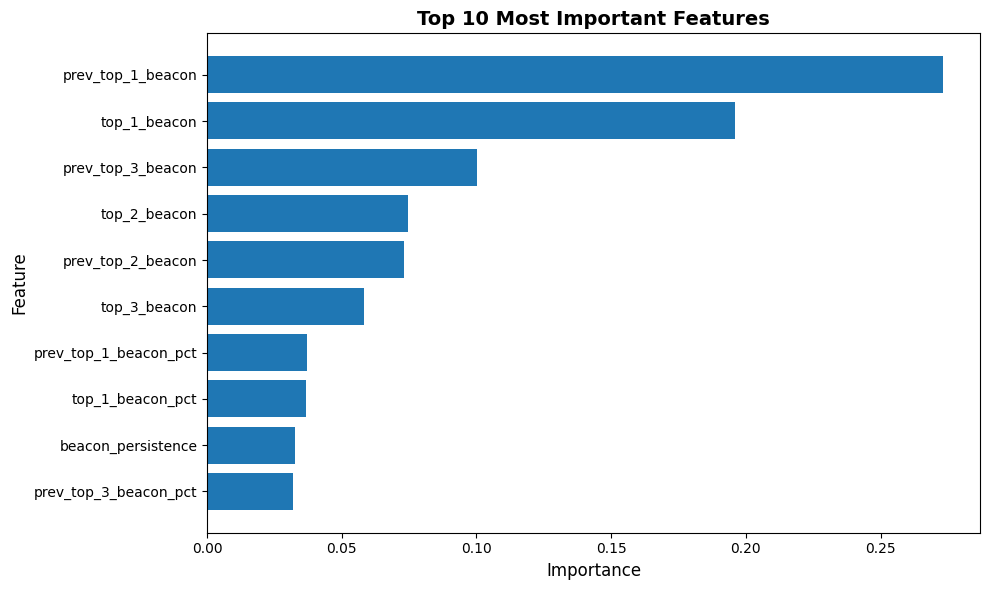

In [17]:
# Bonus: Feature importance analysis
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
feature_names = feature_columns

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*80)
print(importance_df.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['feature'], importance_df.head(10)['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()